## Show difference between 3 subjects in keyboard dataset

In [1]:
import pandas as pd
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from skbio.stats.ordination import pcoa
from skbio import TreeNode
from q2_anomaly_detection.datasets import DietInterventionStudy
from q2_anomaly_detection.transforms import Rarefaction, CLR, AsDense, UniFrac, RarefactionBIOM
from q2_anomaly_detection.benchmark import Benchmark, ColumnValueSplitter, ExternalScorer
from q2_anomaly_detection.utils import as_dense, TrivialScorer
%matplotlib inline

In [2]:
RANDOM_SEED = 825
RAREFACTION_DEPTH = 1000

In [3]:
baseline = Pipeline(steps=[
    ('asdense', AsDense()),
    ('baseline', TrivialScorer()),
])
iso = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('IF', IsolationForest(contamination="auto")),
])
lof = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        )
     ),
])
lof_jaccard = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        metric='jaccard',
        )
     ),
])
ocsvm = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('SVM', OneClassSVM(gamma='auto')
     ),
])

iso_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('IF', IsolationForest(contamination="auto")),
])
lof_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        )
     ),
])
lof_jaccard_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        metric='jaccard',
        )
     ),
])
ocsvm_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('SVM', OneClassSVM(gamma='auto')
     ),
])

In [4]:
# CONVENTION: anomaly scores should be transformed onto (0, 1) where 1 is
#  least anomalous and 0 is the most anomalous
models = {
    'baseline': {
        'model': baseline,
    },
    'IF': {
        'model': iso,
    },
    'LOF': {
        'model': lof,
    },
    'LOF-jaccard': {
        'model': lof_jaccard,
    },
    'ocsvm': {
        'model': ocsvm,
    },
    'IF-clr': {
        'model': iso_clr,
    },
    'LOF-clr': {
        'model': lof_clr,
    },
    'LOF-jaccard-clr': {
        'model': lof_jaccard_clr,
    },
    'ocsvm-clr': {
        'model': ocsvm_clr,
    },
}

In [5]:
# qiita study 232 with trimming to 90 bp and pick closed reference on 97 otus tree
dataset = DietInterventionStudy('data/diet_intervention')
tree = tree_path = 'data/resources/97_otus.tree'

Files already downloaded and verified


In [6]:
table = dataset['table']

In [7]:
table.shape

(7107, 408)

In [8]:
metadata_all = dataset['metadata']

In [9]:
def construct_category(metadata):
    metadata['host_subject_id_for_plant'] = np.nan
    plant_samples = metadata.index[metadata.diet == 'Plant']
    metadata.loc[:, 'host_subject_id_for_plant'].loc[plant_samples] = metadata.host_subject_id[
        plant_samples].to_numpy()
    
    metadata['diet_for_subsample'] = np.nan
    keep_diet_indices = metadata['diet'].sample(len(metadata) // 2).index
    metadata.loc[:, 'diet_for_subsample'].loc[keep_diet_indices] = metadata.diet[keep_diet_indices].to_numpy()


def subset_metadata(metadata_all, table):
    table_ids = set(table.ids())

    # also remove anything that does not have more than RAREFACTION_DEPTH counts
    #  in both 'Plant' and 'Meat'
    table_sum = table.sum(axis='sample')

    insufficient_count_ids = table.ids('sample')[table_sum < RAREFACTION_DEPTH]

    table_ids -= set(insufficient_count_ids)


    metadata = metadata_all.query('host_common_name == "human" & sample_name in @table_ids &'
                                  'diet in ["Plant", "Animal"]'
                                 )
    
    diets_present = metadata[['host_subject_id', 'diet']].groupby('host_subject_id').agg(set)
    diets_sufficient = diets_present.apply(lambda diets: diets >= {'Plant', 'Animal'})
    sufficient_ids = diets_sufficient.loc[diets_sufficient['diet']].index
    
    metadata = metadata.query('host_subject_id in @sufficient_ids')

    return metadata

In [10]:
metadata = subset_metadata(metadata_all, table)

metadata = metadata.set_index('sample_name')

In [11]:
# TRAINING_CATEGORY = 'host_subject_id_for_plant'
# TRUTH_CATEGORY = 'host_subject_id'
# INTEREST_VARIABLE = 'diet'


TRAINING_CATEGORY = 'diet_for_subsample'
TRUTH_CATEGORY = 'diet'
INTEREST_VARIABLE = 'diet'

In [12]:
metadata[INTEREST_VARIABLE].unique()


array(['Plant', 'Animal'], dtype=object)

In [13]:
construct_category(metadata)

/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
table.filter(metadata.index, axis='sample')

7107 x 210 <class 'biom.table.Table'> with 161609 nonzero entries (10% dense)

In [15]:
np.random.seed(RANDOM_SEED)
subtable = table  # table.subsample(RAREFACTION_DEPTH)
submetadata = metadata.loc[metadata.index.isin(subtable.ids('sample'))]

In [16]:
subtable.shape

(7107, 210)

In [17]:
study_ids = subtable.ids('sample')

/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03163427672047906 and the largest is 4.747658449116383.
  RuntimeWarning


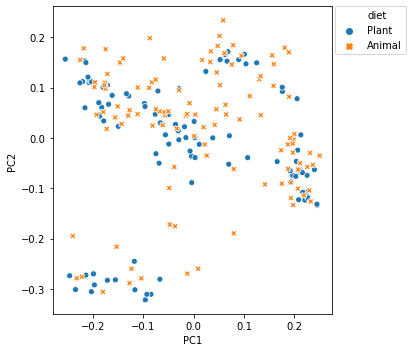

In [18]:
# rarefied_table = Rarefaction(RAREFACTION_DEPTH).fit_transform(as_dense(subtable).astype(int))
# dm = pdist(rarefied_table, metric='jaccard')
# table_for_pcoa = CLR().fit_transform(as_dense(subtable))
# dm = pdist(table_for_pcoa, metric='euclidean')
dm = Pipeline(
    [
        ('rarefy', RarefactionBIOM(RAREFACTION_DEPTH)),
        ('unifrac', UniFrac(tree_path)),
    ]
).fit_transform(subtable)

pcoa_results = pcoa(dm)

pcoa_results.samples.index = study_ids

pcoa_with_metadata = pcoa_results.samples.join(metadata)

plt.subplots(figsize=(10, 5))
ax = sns.scatterplot('PC1', 'PC2',
                     hue=TRUTH_CATEGORY,
                     style=INTEREST_VARIABLE,
                     data=pcoa_with_metadata
                     )
ax.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.savefig('results/clr-pcoa.png')
plt.tight_layout()

## Show the results of an anomaly detection algorithm of one class v. rest


In [19]:
submetadata.shape

(210, 43)

In [20]:
submetadata.groupby([TRUTH_CATEGORY, 'diet']).agg('count')


,,collection_date_publication,collection_time,collection_timestamp,country,day,description,elevation,empo_1,empo_2,empo_3,...,qiita_study_id,sample_type,scientific_name,sex,subjdiet,subjectfood,taxon_id,title,host_subject_id_for_plant,diet_for_subsample
diet,diet,,,,,,,,,,,,,,,,,,,,,
Animal,Animal,111,93,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,0,50
Plant,Plant,99,74,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,55


In [21]:
splitter = ColumnValueSplitter(TRAINING_CATEGORY, TRUTH_CATEGORY)
external_scorer = ExternalScorer()
benchmark = Benchmark(models)
benchmark.set_scorer(external_scorer)
benchmark.set_splitter(splitter)
all_results = benchmark.benchmarking_loop(subtable, submetadata)

/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWa

In [22]:
res_df = all_results.long_form()

In [23]:
res_with_pc = res_df.reset_index().join(
    pcoa_results.samples[['PC1', 'PC2', 'PC3']], on='sample_id'
).join(
    metadata[[INTEREST_VARIABLE]], on='sample_id'
)

In [24]:
pd.set_option("display.max_rows", 101)
all_results.short_form().sort_values('avg_prec', ascending=False)


,model_name,category,roc_auc,avg_prec
8,ocsvm,Plant,0.764742,0.885802
17,ocsvm-clr,Animal,0.733234,0.844435
13,LOF-clr,Animal,0.711707,0.820996
11,IF-clr,Animal,0.644312,0.770285
6,LOF-jaccard,Plant,0.608927,0.760313
2,IF,Plant,0.548116,0.731587
4,LOF,Plant,0.534500,0.724242
14,LOF-jaccard-clr,Plant,0.500000,0.716129
0,baseline,Plant,0.500000,0.716129
16,ocsvm-clr,Plant,0.453112,0.691254


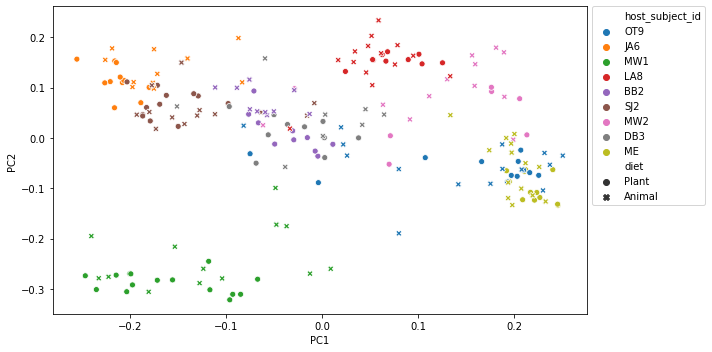

In [25]:
plt.subplots(figsize=(10, 5))
sns.scatterplot('PC1', 'PC2',
                hue='host_subject_id',
                style=INTEREST_VARIABLE,
                data=pcoa_with_metadata)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.tight_layout()

In [26]:
sns.set(font_scale=1.5)

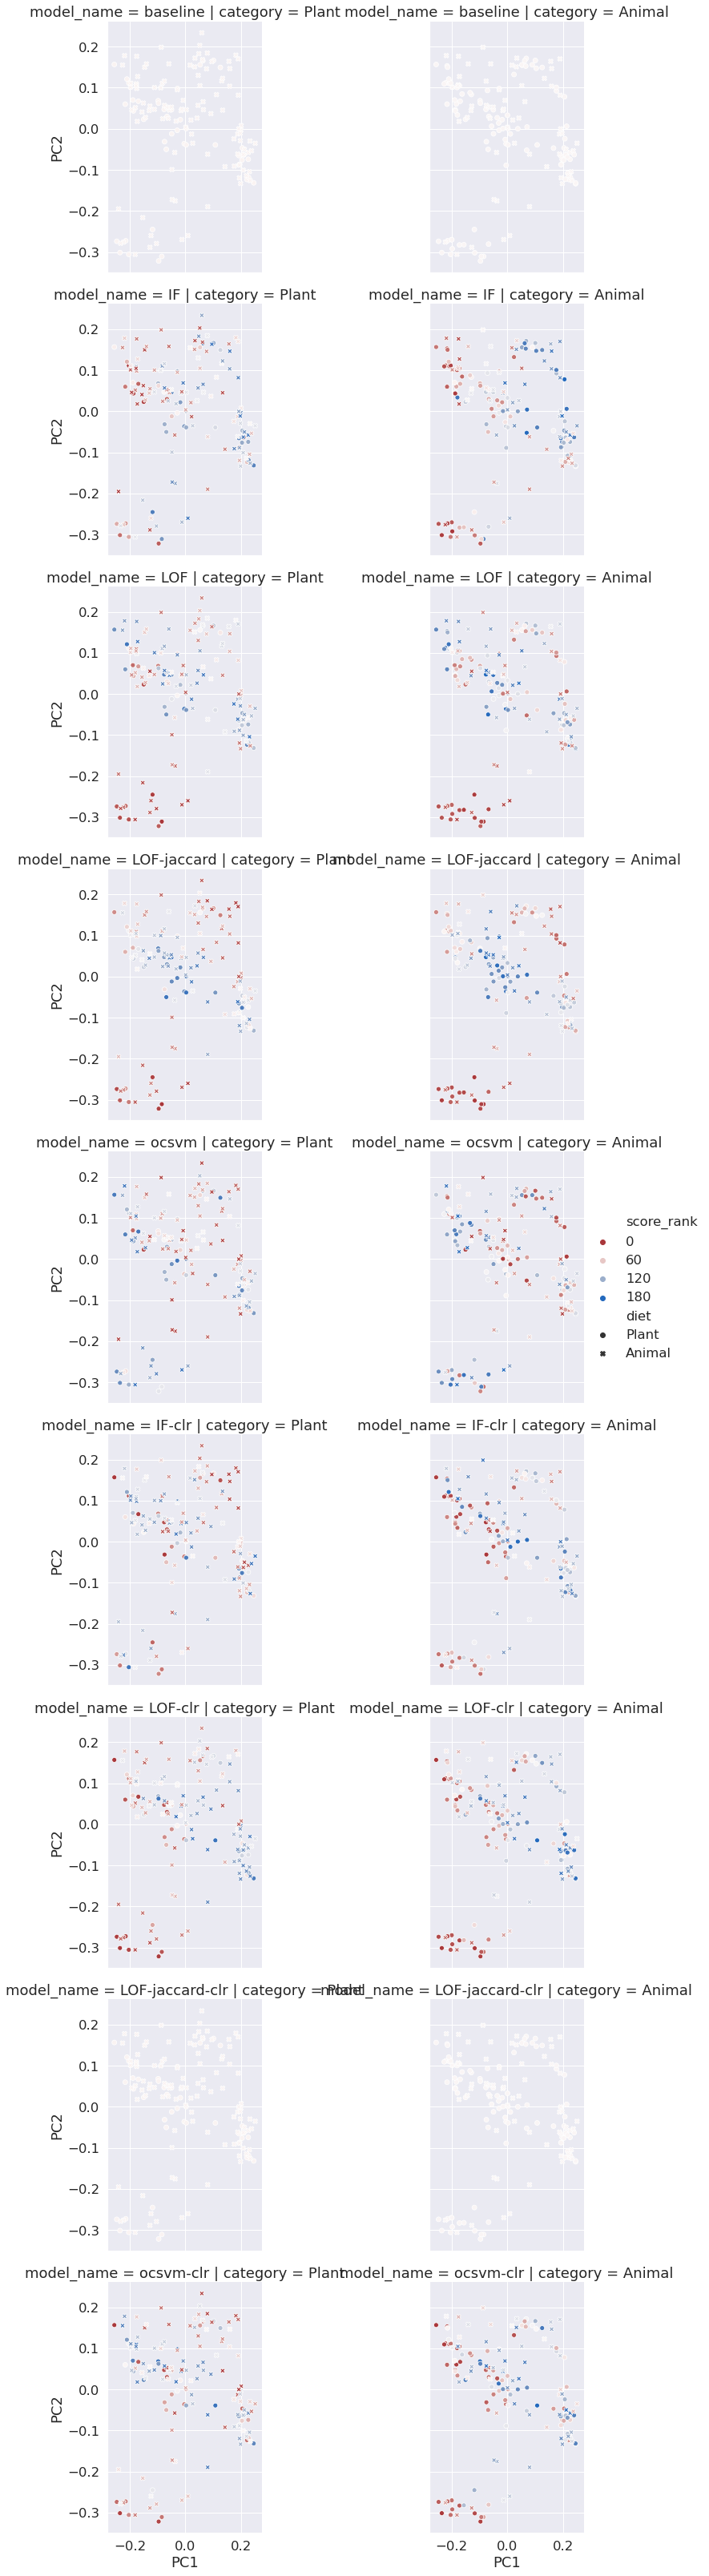

In [27]:
ax = sns.relplot(x='PC1', y='PC2',
            data=res_with_pc,
            col='category',
            row='model_name',
            hue='score_rank',
            palette='vlag_r',
            style=INTEREST_VARIABLE,
            aspect=1,
           )
